# Use LlamaIndex and a Local LLM to Summarize YouTube Videos

## Introduction
This is a short follow up to a recent [article](https://medium.com/@bSharpML/summarize-youtube-videos-with-llamaindex-part-2-baaac5a7d0cd) I wrote on where I showed how to summarize YouTube videos using LlamaIndex and an OpenAI model. We'll do the same here, but instead use a Local LLM.  

[LlamaIndex](https://medium.com/r/?url=https%3A%2F%2Fgpt-index.readthedocs.io%2Fen%2Fstable%2Fexamples%2Fllm%2Fllama_2_llama_cpp.html) supports using LlamaCPP, which is basically a rewrite in C++ of the Llama inference code and allows one to use the language model on a modest piece of [hardware](https://medium.com/r/?url=https%3A%2F%2Ffinbarr.ca%2Fhow-is-llama-cpp-possible%2F). In my case, I'll be running it on a 4 year old Lenovo laptop running Windows 11, with an Intel i7–9750H CPU, 64GB of RAM, and an Nvidia Quadro T200 graphics card. I really need to build a dedicated desktop to do this type of work!

## Installation
The first thing we'll want to do is to create a new python environment and install [llama-cpp-python](https://medium.com/r/?url=https%3A%2F%2Fgithub.com%2Fabetlen%2Fllama-cpp-python). I'll do so with hardware acceleration support, here are the steps I took. In a powershell prompt, e.g. within VSCode, enter the following.

```
$env:CMAKE_ARGS = "-DLLAMA_CUBLAS=on"
$env:FORCE_CMAKE = 1
pip install llama-cpp-python
```
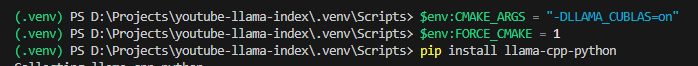

OpenBlas is a basic linear algebra sub-routines backend to help perform fast linear algebra operations. After getting llama-cpp-python installed, you'll want to pip install llama-index and sentence-transformers. Sentence transformers will be used for the [local embedding model](https://medium.com/r/?url=https%3A%2F%2Fgpt-index.readthedocs.io%2Fen%2Fstable%2Fgetting_started%2Finstallation.html%23local-environment-setup).

## Local LMM Setup

In [1]:
import logging
import sys

from llama_index.callbacks import CallbackManager, LlamaDebugHandler
from llama_index.llms import LlamaCPP
from llama_index.llms.llama_utils import messages_to_prompt, completion_to_prompt

logging.basicConfig(stream=sys.stdout, level=logging.INFO)  # Change INFO to DEBUG if you want more extensive logging
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

llama_debug = LlamaDebugHandler(print_trace_on_end=True)
callback_manager = CallbackManager([llama_debug])

llm = LlamaCPP(
    model_url="https://huggingface.co/TheBloke/Llama-2-13B-chat-GGUF/resolve/main/llama-2-13b-chat.Q5_K_M.gguf",
    
    # optionally, you can set the path to a pre-downloaded model instead of model_url
    model_path=None,
    
    temperature=0.0,
    max_new_tokens=1024,
    
    # llama2 has a context window of 4096 tokens, but we set it lower to allow for some wiggle room
    context_window=3900,  # note, this sets n_ctx in the model_kwargs below, so you don't need to pass it there.
    
    # kwargs to pass to __call__()
    generate_kwargs={},
    
    # kwargs to pass to __init__()
    # set to at least 1 to use GPU
    model_kwargs={"n_gpu_layers": 4},
    
    # transform inputs into Llama2 format
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
    verbose=True,
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 0 | VSX = 0 | 


In [ ]:
response = llm.complete("What can you tell me about the Ancient Aliens TV Series?")
print(response.text)

## Create Index

In [ ]:
import os
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext

transcript_directory = "transcripts/ancient-aliens-official"
storage_directory = "storage/ancient-aliens-official/local"

# Add filename as metadata to each chunk associated with a document/transcript
filename_fn = lambda filename: {'episode_title': os.path.splitext(os.path.basename(filename))[0]}
documents = SimpleDirectoryReader(transcript_directory, filename_as_id=True, 
                                  file_metadata=filename_fn).load_data()

# Exclude metadata from the LLM, meaning it won't read it when generating a response.
# Future - consider looping over documents and setting the id_ to basename, instead of fullpath
[document.excluded_llm_metadata_keys.append('episode_title') for document in documents]

# chunk_size - It defines the size of the chunks (or nodes) that documents are broken into when they are indexed by LlamaIndex
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024,
                                               embed_model="local",
                                               callback_manager=callback_manager)

# Build the index
index = VectorStoreIndex.from_documents(documents, service_context=service_context, show_progress=True)

# Persist the index to disk
index.storage_context.persist(persist_dir=storage_directory)

## Load Vector Index

You can use the code below to reload the index again later if needed.

In [2]:
# Now you can load the index from disk when needed, and not rebuild it each time.
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index import StorageContext, load_index_from_storage

transcript_directory = "transcripts/ancient-aliens-official"
storage_directory = "storage/ancient-aliens-official/local"

service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024,
                                               embed_model="local",
                                               callback_manager=callback_manager)

storage_context = StorageContext.from_defaults(persist_dir=storage_directory)
index = load_index_from_storage(storage_context, service_context=service_context)

d:\Projects\youtube-llama-index\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-small-en
Load pretrained SentenceTransformer: BAAI/bge-small-en
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu
Use pytorch device: cpu
INFO:llama_index.indices.loading:Loading all indices.
Loading all indices.
**********
Trace: index_construction
**********


## Query Index

In [8]:
from IPython.display import Markdown, display
from llama_index.prompts import PromptTemplate

query_engine = index.as_query_engine(service_context=service_context,
                                     similarity_top_k=3)

response = query_engine.query("Please summarize the Alien DNA Found in Octopus Genetics Episode in 3 very detailed paragraphs.")
display(Markdown(f"<b>{response}</b>"))

Batches: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]
Llama.generate: prefix-match hit


**********
Trace: query
    |_CBEventType.QUERY ->  223.056776 seconds
      |_CBEventType.RETRIEVE ->  0.086538 seconds
        |_CBEventType.EMBEDDING ->  0.05858 seconds
      |_CBEventType.SYNTHESIZE ->  222.969237 seconds
        |_CBEventType.TEMPLATING ->  0.0 seconds
        |_CBEventType.LLM ->  222.963231 seconds
**********


<b>  Sure! Here is a summary of the "Alien DNA Found in Octopus Genetics" episode in three detailed paragraphs:

In March 2018, a scientific paper sparked a sensation in the press when a team of 33 scientists, including Dr. Chandra Wickramasinghe, claimed that octopuses possess extraterrestrial DNA. The octopus genome contains almost uncanny features, with around 50,000 genes compared to the human's 25,000 genes. This suggests that the octopus is more complex than the human and may have originated from outside of Earth.

As scientists study octopi, they are amazed at what they are finding. The octopus's brain is distributed throughout its body, with brains in its arms as well as the central brain in its head. This allows for incredible adaptability and camouflaging abilities, as the octopus can change its color to match its surroundings almost instantly. Additionally, the octopus has the ability to edit its own genetic code, which suggests that it could rapidly adapt to its environment far faster than other creatures.

Mythological accounts from across the ancient world suggest that the octopus may be related to a race of extraterrestrials that visited Earth thousands of years ago. The octopus has been depicted in various cultures as a deity with bizarre, large eyes, and bas-relief carvings of this creature have been found in places like ancient Crete and Ecuador. This has led some to speculate that the ancients were aware that the octopus is truly alien to this planet. The possibility that the octopus is related to extraterrestrial life has sparked further investigation into its origins and abilities.</b>

In [12]:
query = "What is the Alien nuclear agenda? \n\n" \
        "Please summarize the information into 3 detailed paragraphs, something suitable for a blog post."

response = query_engine.query(query)
display(Markdown(f"<b>{response}</b>"))

Batches: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]
Llama.generate: prefix-match hit


**********
Trace: query
    |_CBEventType.QUERY ->  329.967305 seconds
      |_CBEventType.RETRIEVE ->  0.107104 seconds
        |_CBEventType.EMBEDDING ->  0.067061 seconds
      |_CBEventType.SYNTHESIZE ->  329.860201 seconds
        |_CBEventType.TEMPLATING ->  0.0 seconds
        |_CBEventType.LLM ->  329.850019 seconds
**********


<b>  The concept of an "Alien nuclear agenda" is rooted in the idea that extraterrestrial beings are monitoring human activity, particularly with regards to our use of nuclear weapons. According to former Canadian Defense Minister Paul Hellyer, these extraterrestrial entities are concerned about the devastating effects of nuclear weapons and their potential to destroy entire planets. They have been observing Earth for some time and are aware of the catastrophic consequences of nuclear warfare.

The agenda of these extraterrestrial beings is believed to be twofold. Firstly, they want to ensure that humans do not use nuclear weapons to destroy ourselves and the planet. They have seen the devastating effects of nuclear weapons in the past and are trying to prevent a similar fate from befalling Earth. Secondly, they are interested in humanity's moral and technological development, and may be monitoring our progress with the intention of eventually integrating us into a galactic community.

However, it is also possible that these extraterrestrial entities have a more sinister motive. They may be attempting to control or influence human activity, potentially with negative intentions. The fact that UFO sightings have increased dramatically since the detonation of the atomic bomb in 1945 suggests that there may be a connection between these events and the presence of extraterrestrial beings on Earth. It is also possible that these entities are monitoring our use of nuclear weapons as part of an experiment to test humanity's moral development. Ultimately, the true motives of these extraterrestrial beings remain a mystery, and it may take direct contact with them to reveal their ultimate purpose.</b>

In [13]:
# Print the number of source nodes
num_source_nodes = len(response.source_nodes)
print(f"Number of source nodes: {num_source_nodes}")

# Loop over source nodes and print meta data
for s in response.source_nodes:
    print(f"Node Score: {s.score}")
    print(s.node.metadata)

Number of source nodes: 3
Node Score: 0.8733220834529445
{'episode_title': 'Ancient Aliens THE ALIEN NUCLEAR AGENDA Season 12  History'}
Node Score: 0.8680199306108252
{'episode_title': 'Ancient Aliens US Navy Declassifies New UFO Reports'}
Node Score: 0.8662590362173239
{'episode_title': 'Ancient Aliens Governed by Extraterrestrials Season 11  History'}


In [ ]:
event_pairs = llama_debug.get_llm_inputs_outputs()
print(event_pairs[2][0].payload['formatted_prompt'])

In [ ]:
llama_debug.flush_event_logs()